In [ ]:
import torch
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt

In [12]:
torch.multiprocessing.freeze_support()

In [13]:
images = np.load('mds-misis-dl-captchan/images.npy')  
labels = np.load('mds-misis-dl-captchan/labels.npy')  
test_images = np.load('mds-misis-dl-captchan/images_sub.npy')

In [14]:
BATCH_SIZE = 64
EPOCHS = 30
LR = 1e-3
PATIENCE = 5
LABEL_SMOOTH=0.15

In [15]:
# Convert to tensors
images_tensor = torch.tensor(images.astype('float32')/255.0).permute(0,3,1,2)
labels_tensor = torch.tensor(labels.astype('int64'))
# Split data
X_train, X_val, y_train, y_val = train_test_split(
    images_tensor, labels_tensor, test_size=0.2, random_state=42
)
# Load them...
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
# ..to loader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE,)

class ImageClassifier(torch.nn.Module):
    def __init__(self, num_chanels=3, num_classes=26):
        super().__init__()
        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(num_chanels, 32, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.GELU(), # gain some perfomance
            torch.nn.MaxPool2d(2), # prevent overtrain
            torch.nn.Dropout(0.2),
            
            torch.nn.Conv2d(32, 64, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.GELU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Dropout(0.2),
            
            torch.nn.Conv2d(64, 128, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.GELU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Dropout(0.2),
            
            torch.nn.Conv2d(128, 256, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.GELU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Dropout(0.1)
            
        )

        self.classificator = torch.nn.Sequential(
            torch.nn.AdaptiveAvgPool2d((1, 1)),
            torch.nn.Flatten(),
            torch.nn.Linear(256 ,num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classificator(x)
        return x

# Init model, load weights if exist
if torch.cuda.is_available():
    print("Using CUDA")
    device = torch.device('cuda')
else:
    print("Using CPU")
    device = torch.device('cpu')
model = ImageClassifier().to(device)
if os.path.exists('best_model.pth'):
    model.load_state_dict(torch.load('best_model.pth'))
    model.to(device)
    model.eval()

torch.optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
criterion = torch.torch.nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH)
scheduler = torch.torch.optim.lr_scheduler.ReduceLROnPlateau(torch.optimizer, 'min', patience=3)

def train():
    best_val_acc = 0.0
    no_improve = 0

    loss_hist_train = [0] * EPOCHS
    acc_hist_val = [0] * EPOCHS

    for epoch in range(0, EPOCHS):
        model.train()
        train_loss = 0
        for x_batch, y_batch in tqdm(train_loader, desc=f'Epoch {epoch} [Train]'):
            # transfer tensor to device
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            # Optimzer step
            torch.optimizer.zero_grad()
            loss = criterion(model(x_batch), y_batch)
            loss.backward()
            torch.optimizer.step()
            train_loss += loss.item()

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                preds = model(x_batch).argmax(dim=1)
                correct += (preds == y_batch).sum().item()
                total += y_batch.size(0)

        val_acc = correct / total
        print(f'Epoch {epoch}: Train Loss: {train_loss/len(train_loader)}, Val Acc: {val_acc}')

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= PATIENCE:
                break
        scheduler.step(val_acc)

        loss_hist_train[epoch]=train_loss/len(train_loader)
        acc_hist_val[epoch]=val_acc
    
    return loss_hist_train, acc_hist_val
loss_hist_train, acc_hist_val = train()

Using CUDA


Epoch 0 [Train]:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 0: Train Loss: 1.294715666294098, Val Acc: 0.88225


Epoch 1 [Train]:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1: Train Loss: 1.274181342601776, Val Acc: 0.89075


Epoch 2 [Train]:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 2: Train Loss: 1.2545279364585877, Val Acc: 0.89475


Epoch 3 [Train]:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 3: Train Loss: 1.2394682512283326, Val Acc: 0.89875


Epoch 4 [Train]:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 4: Train Loss: 1.2248553838729859, Val Acc: 0.9025


Epoch 5 [Train]:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 5: Train Loss: 1.1684065141677857, Val Acc: 0.92075


Epoch 6 [Train]:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 6: Train Loss: 1.1547096996307373, Val Acc: 0.92075


Epoch 7 [Train]:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 7: Train Loss: 1.149112561225891, Val Acc: 0.92


Epoch 8 [Train]:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 8: Train Loss: 1.145678265094757, Val Acc: 0.91975


Epoch 9 [Train]:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 9: Train Loss: 1.1389064135551452, Val Acc: 0.92175


Epoch 10 [Train]:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 10: Train Loss: 1.1351829323768616, Val Acc: 0.92125


Epoch 11 [Train]:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 11: Train Loss: 1.1371772656440735, Val Acc: 0.92275


Epoch 12 [Train]:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 12: Train Loss: 1.1362366333007812, Val Acc: 0.923


Epoch 13 [Train]:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 13: Train Loss: 1.134415334701538, Val Acc: 0.92175


Epoch 14 [Train]:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 14: Train Loss: 1.133571762084961, Val Acc: 0.92125


Epoch 15 [Train]:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 15: Train Loss: 1.1344211683273315, Val Acc: 0.9225


Epoch 16 [Train]:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 16: Train Loss: 1.1356357998847961, Val Acc: 0.92275


Epoch 17 [Train]:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 17: Train Loss: 1.1352097353935242, Val Acc: 0.92275


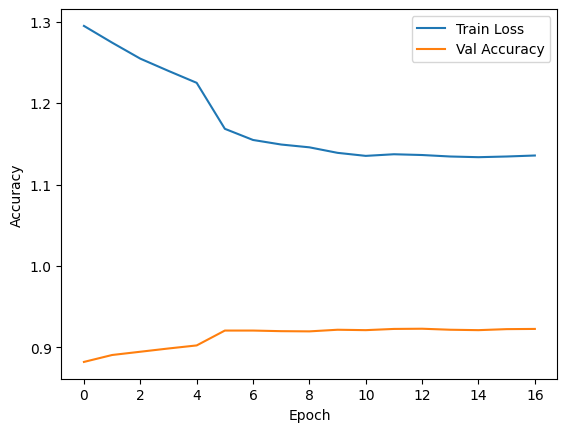

In [16]:
loss_hist_train_np = np.array(loss_hist_train)
acc_hist_val_np = np.array(acc_hist_val)

plt.plot(loss_hist_train_np[loss_hist_train_np.nonzero()], label='Train Loss')
plt.plot(acc_hist_val_np[acc_hist_val_np.nonzero()], label='Val Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [17]:
images_tensor = torch.tensor(test_images.astype('float32')/255.0).permute(0,3,1,2)
test_loader = torch.utils.data.DataLoader(images_tensor, batch_size=BATCH_SIZE)

model.load_state_dict(torch.load('best_model.pth'))
model.eval()
all_predictions = []
with torch.no_grad():
    for batch in test_loader:
        x_batch = batch.to(device)
        outputs = model(x_batch)
        _, predicted = torch.max(outputs, dim=1)
        all_predictions.extend(predicted.cpu().numpy())

submission = pd.DataFrame({
    'id': np.arange(len(all_predictions)),
    'Category': all_predictions
})
submission.to_csv('submission.csv', index=False)